##### **Data source**

The data used here was extracted from ChEMBL database by using ChEMBL web resource client in Python. The details of all the steps taken to reach the final .csv file could be seen in these earlier posts - [post 1](https://jhylin.github.io/Data_in_life_blog/posts/16_ML2-1_Decision_tree/1_data_col_prep.html) and [post 2](https://jhylin.github.io/Data_in_life_blog/posts/16_ML2-1_Decision_tree/2_data_prep_tran.html) (yes, it took quite a while to clean the data, so it was splitted into two posts).

-   The final .csv file used to train the model was named, "ache_2d_chembl.csv"

-   The earlier version without any RDKit 2D descriptors calculated was named, "ache_chembl.csv"

-   Both files should be in a GitHub repository called, "[ML2-1_decision_tree](https://github.com/jhylin/ML2-1_decision_tree)" or in my [blog repository](https://github.com/jhylin/Data_in_life_blog), under "posts" folder (look for "16_ML2-1_Decision_tree" folder)

<br>

##### **Estimate experimental errors**

This part was about estimating the impact of experimental errors (pKi values) on the predictive machine learning (ML) models. It was also needed to estimate the maximum possible correlation that could be drawn from the dataset prepared from the previous two posts. I supposed it made more sense if this was done prior to building the ML model, so this wouldn't be forgotten or missed, as we know that real-life is full of many imperfections.

This subsection was inspired by Pat Walters' posts, which have discussed about estimating errors for experimental data with code links available in these posts:

-   [How Good Could (Should) My Models Be?](http://practicalcheminformatics.blogspot.com/2019/07/how-good-could-should-my-models-be.html) - a reference paper [@Brown2009] was mentioned as the simulation basis for estimating the impact of experimental errors on the correlation from a predictive ML model

-   [Getting Real with Molecular Property Prediction](http://practicalcheminformatics.blogspot.com/2023/06/getting-real-with-molecular-property.html) (under subsection of "How Well Should We Be Able to Model the Data?")

To get started, all the required libraries were loaded as below.

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn import tree

Imported the preprocessed data from previous posts.

In [2]:
# Import data
dtree = pd.read_csv("ache_2d_chembl.csv")
dtree.drop(columns = ["Unnamed: 0"], inplace=True)
dtree.head()

,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL60745,8.787812,NaN,245.041526,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
1,CHEMBL208599,10.585027,NaN,298.123676,0.388889,2,2,4,3,21,...,4.331775,2,0,2,1,1,2,0,0,0
2,CHEMBL95,6.821023,4.0,198.115698,0.307692,2,2,3,2,15,...,2.014719,1,0,1,1,1,2,0,0,0
3,CHEMBL173309,7.913640,NaN,694.539707,0.666667,8,0,2,8,50,...,2.803680,0,0,0,2,0,2,0,0,0
4,CHEMBL1128,6.698970,4.0,201.092042,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0


The pKi column was used in the code below as it contained the experimental values (calculated from measured Ki values, usually derived from countless lab experiments) collected from different scientific literatures or other sources as stated in ChEMBL. The aim was to simulate pKi values with experimental errors added to them.

*Code used for the rest of the subsection were adapted with thanks from Pat Walters' "[maximum_correlation.ipynb](https://github.com/PatWalters/maximum_correlation/blob/master/maximum_correlation.ipynb)" with my own added comments for further explanations*

In [3]:
# Save exp data (pKi) as an object
data = dtree["pKi"]
# Save the object as a list
data_ls = [data]

# Trial 3-, 5- & 10-fold errors
for fold in (3, 5, 10):
    # Retrieve error samples randomly from a normal distribution
    # Bewteen 0 and log10 of number-fold 
    # for the length of provided data only
    error = np.random.normal(0, np.log10(fold), len(data))
    data_ls.append(error + data)

# Convert data_ls to dataframe
dtree_err = pd.DataFrame(data_ls)
# Re-align dataframe (switch column header & index)
dtree_err = dtree_err.transpose()
# Rename columns
dtree_err.columns = ["pKi", "3-fold", "5-fold", "10-fold"]
print(dtree_err.shape)
dtree_err.head()

(481, 4)


,pKi,3-fold,5-fold,10-fold
0,8.787812,8.271683,8.414144,8.014570
1,10.585027,11.387520,9.884872,10.415161
2,6.821023,6.948352,6.973230,7.893612
3,7.913640,8.414064,7.624174,6.170208
4,6.698970,6.728436,7.237513,6.969902


Melting the created dtree_err so it could be plotted later (noticed there should be an increased number of rows after re-stacking the data).

In [4]:
# Melt the dtree_err dataframe 
# to make error values in one column (for plotting)
dtree_err_melt = dtree_err.melt(id_vars = "pKi")
print(dtree_err_melt.shape)
dtree_err_melt.head()

(1443, 3)


,pKi,variable,value
0,8.787812,3-fold,8.271683
1,10.585027,3-fold,11.387520
2,6.821023,3-fold,6.948352
3,7.913640,3-fold,8.414064
4,6.698970,3-fold,6.728436


Presenting this in regression plots.

*Note: There was a matplotlib bug which would always show a tight_layout user warning for FacetGrid plots in seaborn (the lmplot used below). Seaborn was built based on matplotlib so unsurprisingly this occurred (this [GitHub issue link](https://github.com/matplotlib/matplotlib/issues/26290) might explain it). I have therefore temporarily silenced this user warning for the sake of post publication.*

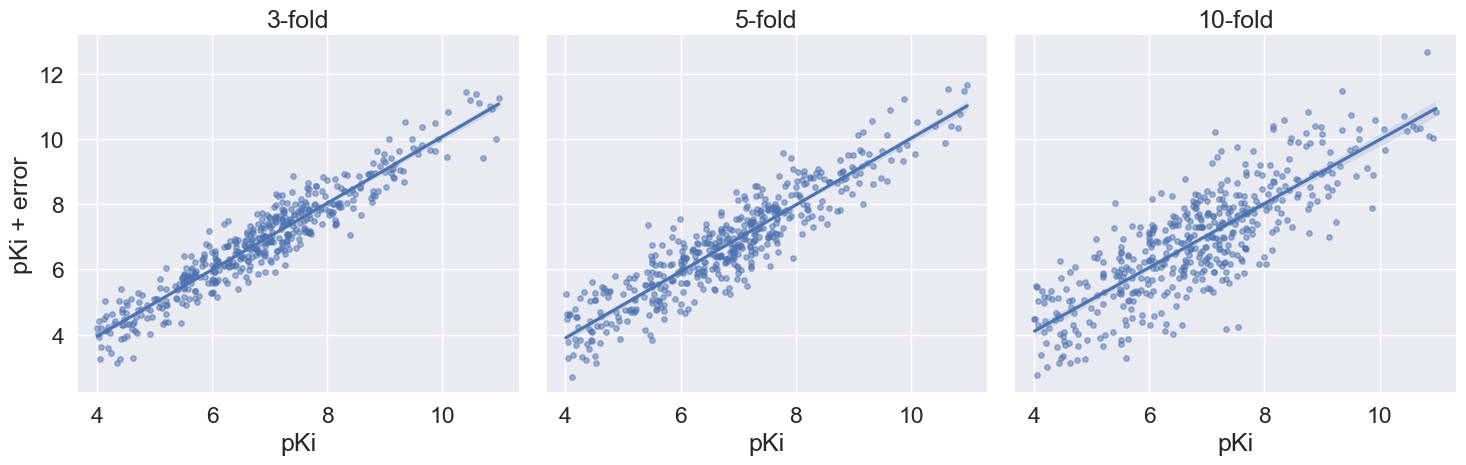

In [5]:
# To silence the tight-layout user warning
import warnings
warnings.filterwarnings("ignore")

# variable = error-fold e.g. 3-fold
# value = pKi value plus error
sns.set_theme(font_scale = 1.5)
plot = sns.lmplot(
    x = "pKi", 
    y = "value", 
    col = "variable", 
    data = dtree_err_melt, 
    # alpha = mark’s opacity (low - more transparent)
    # s = mark size (increase with higher number)
    scatter_kws = dict(alpha = 0.5, s = 15)
    )
title_list = ["3-fold", "5-fold", "10-fold"]
for i in range(0, 3):
    plot.axes[0, i].set_ylabel("pKi + error")
    plot.axes[0, i].set_title(title_list[i])

Simulating the impact of error on the correlation between experimental pKi and also pKi with errors (3-fold, 5-fold and 10-fold). R^2^ calculated using [*scikit-learn*](https://scikit-learn.org/stable/modules/model_evaluation.html#r2-score) was introduced in the code below.

In [6]:
# Calculating r2 score (coefficient of determination) 
# based on 1000 trials for each fold
# note: data = dtree["pKi"]

# Create an empty list for correlation
cor_ls = []
for fold in [3, 5, 10]:
    # Set up 1000 trials
    for i in range(0, 1000):
        error = np.random.normal(0, np.log10(fold), len(data))
        cor_ls.append([r2_score(data, data + error), f"{fold}-fold"])

# Convert cor_ls into dataframe
err_df = pd.DataFrame(cor_ls, columns = ["r2", "fold_error"])
err_df.head()

,r2,fold_error
0,0.889425,3-fold
1,0.896993,3-fold
2,0.885270,3-fold
3,0.898033,3-fold
4,0.887968,3-fold


Plotting the R^2^ and fold-errors as violin plots.

[Text(0.5, 0, 'Fold error'), Text(0, 0.5, 'R$^2$')]

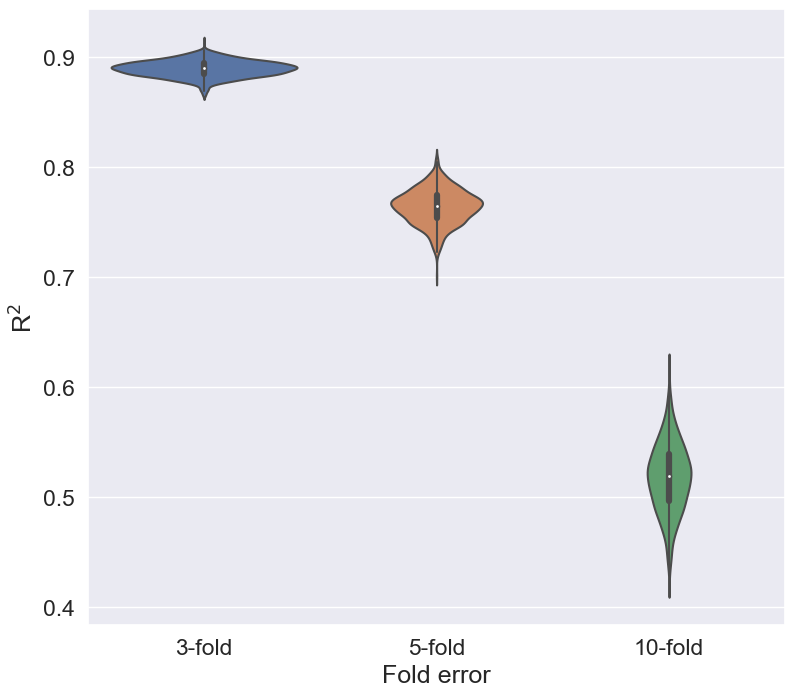

In [7]:
sns.set_theme(rc = {"figure.figsize": (9, 8)}, font_scale = 1.5)
vplot = sns.violinplot(x = "fold_error", y = "r2", data = err_df)
vplot.set(xlabel = "Fold error", ylabel = "R$^2$")

This definitely helped a lot with visualising the estimated errors for the experimental Ki values curated in ChEMBL for this specific protein target (CHEMBL220, acetylcholinesterase (AChE)). The larger the error-fold, the lower the R^2^, and once the experimental error reached 10-fold, we could see an estimated R^2^ (maximum correlation) with its median sitting below 0.55, indicating a likely poor predictive ML model if it was built based on these data with the estimated 10-fold experimental errors.

<br>

##### **Check max phase distribution**

At this stage, I've planned to do model training on compounds with max phase 4 (i.e. prescription medicines), so this would somewhat be an attempt to mirror real-life scenarios for the ML prediction model.

Max phases were assigned to each ChEMBL-curated compound according to this [ChEMBL FAQ link](https://chembl.gitbook.io/chembl-interface-documentation/frequently-asked-questions/drug-and-compound-questions) (under the question of "What is max phase?"). As quoted from this ChEMBL FAQ link, a max phase 4 compound means:

> "Approved (4): A marketed drug e.g. AMINOPHYLLINE (CHEMBL1370561) is an FDA approved drug for treatment of asthma."

Checking out the actual counts of each max phase group in the dataset.

In [8]:
dtree[["molecule_chembl_id", "max_phase"]].groupby("max_phase").count()

,molecule_chembl_id
max_phase,
-1.0,2
2.0,2
3.0,1
4.0,10


There was only a very small number of compounds with max phase 4 assigned (a total count of 10, which was also unsurprising since there weren't many AChE inhibitors used as prescription medications for dementia - some of the well-known examples were donepezil, galantamine and rivastigmine).

Filling in actual "null" labels for all "NaN" rows in the "max_phase" columns to help with filtering out these compounds later on.

In [9]:
dtree["max_phase"].fillna("null", inplace=True)
dtree.head()

,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL60745,8.787812,null,245.041526,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
1,CHEMBL208599,10.585027,null,298.123676,0.388889,2,2,4,3,21,...,4.331775,2,0,2,1,1,2,0,0,0
2,CHEMBL95,6.821023,4.0,198.115698,0.307692,2,2,3,2,15,...,2.014719,1,0,1,1,1,2,0,0,0
3,CHEMBL173309,7.913640,null,694.539707,0.666667,8,0,2,8,50,...,2.803680,0,0,0,2,0,2,0,0,0
4,CHEMBL1128,6.698970,4.0,201.092042,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0


<br>

##### **Sanity check on the dataframe**

This was just another sanity check for myself on the dtree dataframe - making sure there weren't any "NaN" cells in it (so dropping any "NaN" again, even though I might have already done this as one of the steps during data preprocessing).

In [10]:
dtree.dropna()
print(dtree.shape)
dtree.head()

(481, 25)


,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL60745,8.787812,null,245.041526,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
1,CHEMBL208599,10.585027,null,298.123676,0.388889,2,2,4,3,21,...,4.331775,2,0,2,1,1,2,0,0,0
2,CHEMBL95,6.821023,4.0,198.115698,0.307692,2,2,3,2,15,...,2.014719,1,0,1,1,1,2,0,0,0
3,CHEMBL173309,7.913640,null,694.539707,0.666667,8,0,2,8,50,...,2.803680,0,0,0,2,0,2,0,0,0
4,CHEMBL1128,6.698970,4.0,201.092042,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0


<br>

##### **Model building**

###### **Training data based on max phase 4 compounds**

So here I wanted to separate the collected data by splitting the compounds into two groups based on their assigned max phases. Compounds with max phase 4 were chosen as the training data, and the rest of the compounds with max phases of "null" would be the testing data.

In [11]:
# Create a df for compounds with max phase 4 only
dtree_mp4 = dtree[dtree["max_phase"] == 4]
dtree_mp4

,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
2,CHEMBL95,6.821023,4.0,198.115698,0.307692,2,2,3,2,15,...,2.014719,1,0,1,1,1,2,0,0,0
4,CHEMBL1128,6.698970,4.0,201.092042,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
6,CHEMBL640,6.000000,4.0,235.168462,0.461538,4,3,1,4,17,...,1.791687,0,0,0,1,0,1,0,0,0
9,CHEMBL502,7.688246,4.0,379.214744,0.458333,4,0,4,4,28,...,2.677222,1,1,2,2,0,2,0,1,1
131,CHEMBL481,7.296709,4.0,586.279135,0.515152,10,1,7,10,43,...,3.632560,0,4,4,1,2,3,0,2,2
133,CHEMBL360055,4.431798,4.0,510.461822,0.800000,6,0,1,6,36,...,3.257653,0,0,0,1,0,1,0,0,0
160,CHEMBL1025,5.221849,4.0,184.066459,1.000000,3,0,0,5,11,...,3.345144,0,0,0,0,0,0,0,0,0
171,CHEMBL659,6.522879,4.0,287.152144,0.529412,4,1,4,4,21,...,4.226843,1,2,3,1,0,1,0,0,0
180,CHEMBL1200970,4.607303,4.0,348.142697,0.368421,2,0,3,4,23,...,4.223591,0,1,1,2,0,2,0,0,0
195,CHEMBL1677,6.995679,4.0,234.092376,0.307692,2,2,3,3,16,...,3.218715,1,0,1,1,1,2,0,0,0


Making sure donepezil and galantamine were in this dtree_mp4 dataframe, so the model training would be based on these medicines and also other max phase 4 AChE inhibitors.

The screenshots of both medicines were taken from ChEMBL website:

![Screenshot of donepezil (parent drug form) with its molecule ChEMBL ID](donepezil_chembl.png)

![Screenshot of galantamine (parent drug form) with its molecule ChEMBL ID](galantamine_chembl.png)

The following regex string check confirmed that these two compounds were in the dtree_mp4 dataframe - row indices 9 and 171 contained these two drugs.

In [12]:
list_ache_inh = ["CHEMBL502", "CHEMBL659"]
dtree_mp4["molecule_chembl_id"].str.contains(r"|".join(list_ache_inh))

2      False
4      False
6      False
9       True
131    False
133    False
160    False
171     True
180    False
195    False
Name: molecule_chembl_id, dtype: bool

Setting up the features for the training set.

In [13]:
# Set X (features) for max phase 4 compounds
X_mp4_df = dtree_mp4[['mw', 'fsp3', 'n_lipinski_hba', 'n_lipinski_hbd', 'n_rings', 'n_hetero_atoms', 'n_heavy_atoms', 'n_rotatable_bonds', 'n_radical_electrons', 'tpsa', 'qed', 'clogp', 'sas', 'n_aliphatic_carbocycles', 'n_aliphatic_heterocyles', 'n_aliphatic_rings', 'n_aromatic_carbocycles', 'n_aromatic_heterocyles', 'n_aromatic_rings', 'n_saturated_carbocycles', 'n_saturated_heterocyles', 'n_saturated_rings']]

# Convert X_mp4_df to numpy array
X_mp4 = X_mp4_df.to_numpy()
X_mp4

array([[ 1.98115698e+02,  3.07692308e-01,  2.00000000e+00,
         2.00000000e+00,  3.00000000e+00,  2.00000000e+00,
         1.50000000e+01,  0.00000000e+00,  0.00000000e+00,
         3.89100000e+01,  7.06488238e-01,  2.69580000e+00,
         2.01471913e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         2.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.01092042e+02,  4.00000000e-01,  2.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  3.00000000e+00,
         1.30000000e+01,  2.00000000e+00,  0.00000000e+00,
         2.02300000e+01,  6.08112327e-01, -1.01700000e+00,
         3.18586632e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 2.35168462e+02,  4.61538462e-01,  4.00000000e+00,
         3.00000000e+00,  1.00000000e+00,  4.00000000e+00,
    

Setting up the target for the training set.

In [14]:
# Set y (target) for max phase 4 compounds
y_mp4_df = dtree_mp4["pKi"]

# Convert y_mp4_df to numpy array
y_mp4 = y_mp4_df.to_numpy()
y_mp4

array([6.82102305, 6.69897   , 6.        , 7.68824614, 7.29670862,
       4.43179828, 5.22184875, 6.52287875, 4.60730305, 6.99567863])

The DecisionTreeRegressor() was fitted on the compounds with max phase 4 as shown below, keeping tree depth at 3 for now to avoid complicating the overall tree graph (the deeper the tree, the more branches - potentially might overfit and create noises for the model).

In [15]:
ache_tree_mp4 = tree.DecisionTreeRegressor(max_depth=3, random_state=1)
ache_tree_mp4 = ache_tree_mp4.fit(X_mp4, y_mp4)

<br>

###### ***scikit-learn* tree plot**

A simple decision tree plot based on *scikit-learn's* plot_tree() was shown below.

[Text(0.5909090909090909, 0.875, 'clogp <= 4.901\nsquared_error = 1.144\nsamples = 10\nvalue = 6.228'),
 Text(0.36363636363636365, 0.625, 'n_aromatic_rings <= 1.5\nsquared_error = 0.516\nsamples = 8\nvalue = 6.656'),
 Text(0.18181818181818182, 0.375, 'n_aromatic_rings <= 0.5\nsquared_error = 0.33\nsamples = 4\nvalue = 6.111'),
 Text(0.09090909090909091, 0.125, 'squared_error = 0.0\nsamples = 1\nvalue = 5.222'),
 Text(0.2727272727272727, 0.125, 'squared_error = 0.088\nsamples = 3\nvalue = 6.407'),
 Text(0.5454545454545454, 0.375, 'n_rotatable_bonds <= 2.0\nsquared_error = 0.108\nsamples = 4\nvalue = 7.2'),
 Text(0.45454545454545453, 0.125, 'squared_error = 0.008\nsamples = 2\nvalue = 6.908'),
 Text(0.6363636363636364, 0.125, 'squared_error = 0.038\nsamples = 2\nvalue = 7.492'),
 Text(0.8181818181818182, 0.625, 'mw <= 429.302\nsquared_error = 0.008\nsamples = 2\nvalue = 4.52'),
 Text(0.7272727272727273, 0.375, 'squared_error = 0.0\nsamples = 1\nvalue = 4.607'),
 Text(0.9090909090909091, 

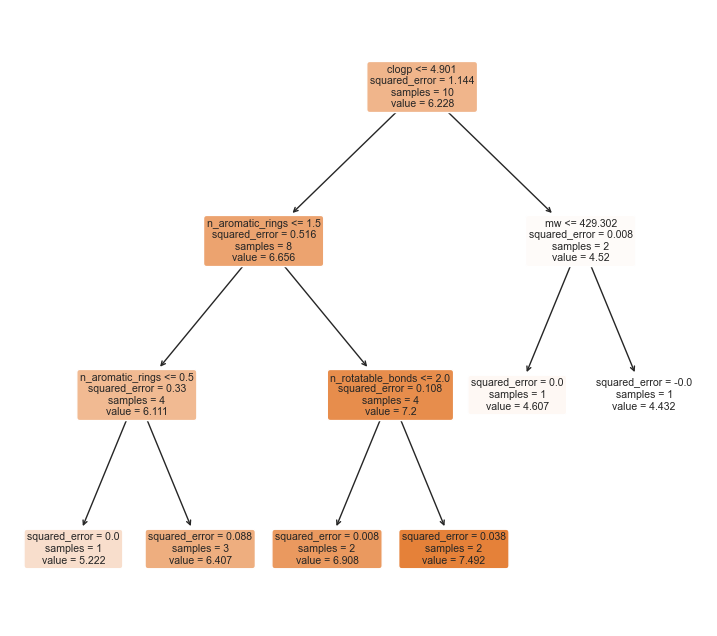

In [16]:
tree.plot_tree(ache_tree_mp4, feature_names=list(X_mp4_df.columns), filled=True, rounded=True)

###### ***scikit-learn* tree plot in texts**

It could also be in the text form.

In [17]:
from sklearn.tree import export_text

text = export_text(ache_tree_mp4, feature_names=list(X_mp4_df.columns))
print(text)

|--- clogp <= 4.90
|   |--- n_aromatic_rings <= 1.50
|   |   |--- n_aromatic_rings <= 0.50
|   |   |   |--- value: [5.22]
|   |   |--- n_aromatic_rings >  0.50
|   |   |   |--- value: [6.41]
|   |--- n_aromatic_rings >  1.50
|   |   |--- n_rotatable_bonds <= 2.00
|   |   |   |--- value: [6.91]
|   |   |--- n_rotatable_bonds >  2.00
|   |   |   |--- value: [7.49]
|--- clogp >  4.90
|   |--- mw <= 429.30
|   |   |--- value: [4.61]
|   |--- mw >  429.30
|   |   |--- value: [4.43]



<br>

###### ***graphviz* tree plot**

The graphviz version, which showed a small variation in graph presentation, seemed to be much larger in size and easier to view.

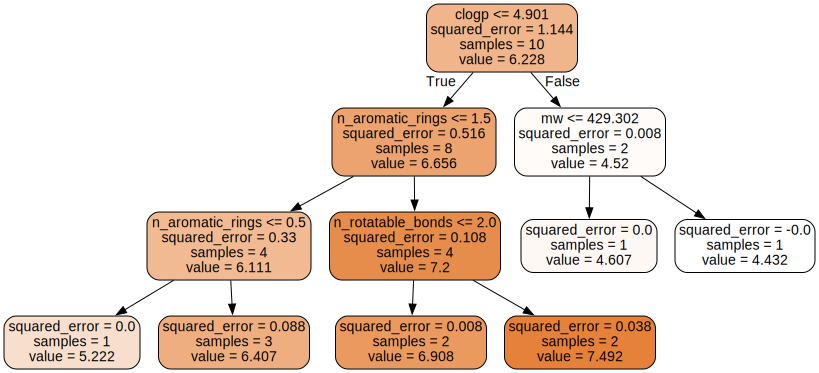

In [18]:
import graphviz

dot_data = tree.export_graphviz(ache_tree_mp4, out_file=None, feature_names=list(X_mp4_df.columns), filled=True, rounded=True, special_characters=False)

graph = graphviz.Source(dot_data)
graph

<br>

###### ***dtreeviz* tree plot**

The following was a dtreeviz version of the decision tree, which actually included the regression plots of different molecular features e.g. clogp versus the target value of pKi. It seemed a bit more intuitive as these plots clearly showed where the threshold cut-offs would be for each feature (molecular descriptors). The GitHub repository link for dtreeviz could be accessed [here](https://github.com/parrt/dtreeviz).

*Note: it might be smaller in size and not as clear as the graphviz version in the published version of the post, but if the code was run in any IDE, it should be larger to view, and potentailly could be saved as a PDF file*

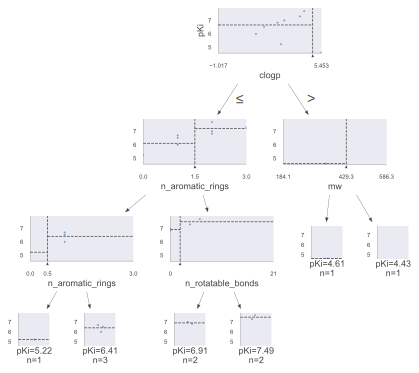

In [19]:
import dtreeviz 

viz = dtreeviz.model(ache_tree_mp4, X_train=X_mp4, y_train=y_mp4, target_name="pKi", feature_names=list(X_mp4_df.columns))
viz.view()

<br>

###### **Testing and predicting data based on max phase of null compounds**

In [20]:
# Compounds with max phase as "null"
dtree_mp_null = dtree[dtree["max_phase"] == "null"]
print(dtree_mp_null.shape)
dtree_mp_null.head() 

(466, 25)


,molecule_chembl_id,pKi,max_phase,mw,fsp3,n_lipinski_hba,n_lipinski_hbd,n_rings,n_hetero_atoms,n_heavy_atoms,...,sas,n_aliphatic_carbocycles,n_aliphatic_heterocyles,n_aliphatic_rings,n_aromatic_carbocycles,n_aromatic_heterocyles,n_aromatic_rings,n_saturated_carbocycles,n_saturated_heterocyles,n_saturated_rings
0,CHEMBL60745,8.787812,null,245.041526,0.400000,2,1,1,3,13,...,3.185866,0,0,0,1,0,1,0,0,0
1,CHEMBL208599,10.585027,null,298.123676,0.388889,2,2,4,3,21,...,4.331775,2,0,2,1,1,2,0,0,0
3,CHEMBL173309,7.913640,null,694.539707,0.666667,8,0,2,8,50,...,2.803680,0,0,0,2,0,2,0,0,0
5,CHEMBL102226,4.698970,null,297.152928,0.923077,3,0,0,5,18,...,2.965170,0,0,0,0,0,0,0,0,0
7,CHEMBL103873,5.698970,null,269.121628,0.909091,3,0,0,5,16,...,3.097106,0,0,0,0,0,0,0,0,0


There were 466 compounds with max phase as "null", meaning they were pre-clinical compounds. This was confirmed through the answer from ChEMBL FAQ link, a max phase of "null" compound means:

> "Preclinical (NULL): preclinical compounds with bioactivity data e.g. is a preclinical compound with bioactivity data that has been extracted from scientific literature. However, the sources of drug and clinical candidate drug information in ChEMBL do not show that this compound has reached clinical trials and therefore the max_phase is set to null."

Again, setting up the features for the testing dataset.

In [21]:
X_mp_test_df = dtree_mp_null[['mw', 'fsp3', 'n_lipinski_hba', 'n_lipinski_hbd', 'n_rings', 'n_hetero_atoms', 'n_heavy_atoms', 'n_rotatable_bonds', 'n_radical_electrons', 'tpsa', 'qed', 'clogp', 'sas', 'n_aliphatic_carbocycles', 'n_aliphatic_heterocyles', 'n_aliphatic_rings', 'n_aromatic_carbocycles', 'n_aromatic_heterocyles', 'n_aromatic_rings', 'n_saturated_carbocycles', 'n_saturated_heterocyles', 'n_saturated_rings']]

# Convert X_mp_test_df to numpy array
X_mp_test = X_mp_test_df.to_numpy()
X_mp_test

array([[2.45041526e+02, 4.00000000e-01, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.98123676e+02, 3.88888889e-01, 2.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.94539707e+02, 6.66666667e-01, 8.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.11152144e+02, 3.15789474e-01, 4.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.68096076e+02, 9.23076923e-01, 4.00000000e+00, ...,
        0.00000000e+00, 2.00000000e+00, 2.00000000e+00],
       [2.46136828e+02, 5.00000000e-01, 4.00000000e+00, ...,
        0.00000000e+00, 3.00000000e+00, 3.00000000e+00]])

Then setting up the target for the testing set.

In [22]:
y_test = ache_tree_mp4.predict(X_mp_test)

The trained model, ache_tree_mp4, was used to predict on the testing dataset (max phase of null compounds).

In [23]:
ache_tree_mp4 = ache_tree_mp4.fit(X_mp_test, y_test)

Using the graphviz graph version to show the decision tree on the testing set, as the prediction result.

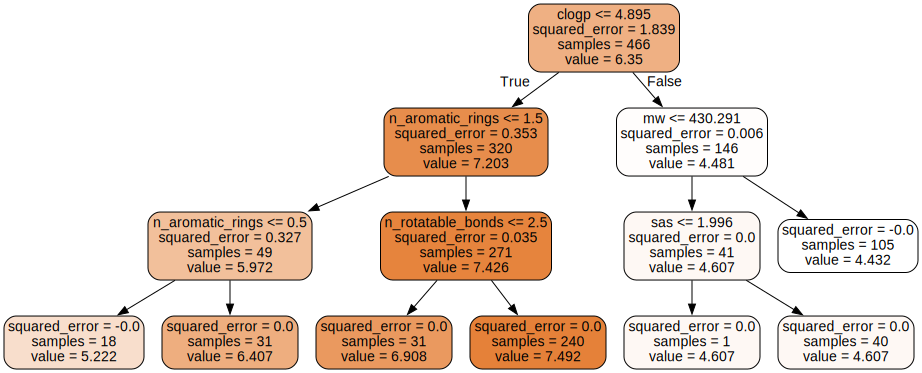

In [24]:
dot_data = tree.export_graphviz(ache_tree_mp4, out_file=None, feature_names=list(X_mp_test_df.columns), filled=True, rounded=True, special_characters=False)

graph = graphviz.Source(dot_data)
graph

<br>

##### **Discussions**

Because of the small amount of training data, this might hint at using an ensemble approach in the future, where model averaging would be derived from a bunch of tree models rather than using a single tree model, which was what I did here. The reason I started with one tree was because it was no point in building a multiple-tree model if one had no clue about how one tree was built. To learn as much as possible, I had to dissect the multiple-tree version first to focus on one tree at a time.

One thing I'd like to mention was that rivastigmine was not included in the training dataset because it was actually not a pure AChE inhibitor (as it was also a butyrylcholinesterase (BChE) inhibitor), since my focus was purely on AChE at this time, this particular drug was unfortunately excluded. However, I did make sure the other two drugs (donepezil and galantamine) were included in the training dataset. One possible thing to do in the future if I want to improve this was to add BChE as another protein target and perhaps add this as an additional dataset towards the model.

As described in the subsection of "Estimate experimental errors", there were experimental errors of 3-fold, 5-fold and 10-fold estimated based on the provided pKi data. With the prediction model used in this post, the estimated experimental errors would need to be taken into consideration, particularly at the time when the model was being investigated during the model evaluation and validation step (however due to the length of series 2.1 posts, I decided not to add this step yet, but would try to look at this later in the multiple tree model series if this applies).

A bit about the last decision tree plot, tentatively clogp (calculated partition coefficient) might be the crucial molecular feature in deciding whether a molecule might be closer to being an AChE inhibitor. Other important molecular features also included the number of aromatic rings, molecular weights, solvent accessible surface area and others (I've set the random state to 1 for now, so hopefully the result will be reproducible as I realised my old code without it always generated different tree plots, then all of the sudden I remembered that I forgot to set the random state of the estimator, so this was added).

Since the type of AChE inhibitors was not the focus of this series, I won't go into details about which value of pKi or Ki would lead to the ideal AChE inhibitor (the well-known Cheng-Prusoff equation [@Cheng1973] might also lead to many discussions about Ki and IC50 values). This is because there are at least two types of AChE inhibitors available - reversible and irreversible [@Colovic2013]. Donepezil, galantamine and rivastigmine mentioned previously are the commonly known reversible AChE inhibitors. The irreversible type, as the name suggested, is usually used as insecticides or nerve agents. Another reason is that I didn't go into details checking all of the identities for the 10 max phase 4 compounds used in the training set, as I only really made sure that donepezil and galantamine were included in the 10 molecules. If I were to re-model again purely on reversible AChE inhibitors targeting dementia or Alzheimer's disease, I think I had to be quite sure of what I was training the model with, i.e. excluding irreversible AChE inhibitors from the training set.

However, if our aim was to only find novel AChE inhibitors in a general manner, one of the ways to check post-model building would be to re-run the dataframe again on compounds with max phase as null, including the molecular feature names to find out which compounds were at the predicted threshold cut-off values to see if their corresponding pKi values (note: these preclinical compounds had Ki values extracted from literature sources etc.) would match the predicted ones. One caveat of this method was that there might be pre-existing experimental errors in all the obtained and recorded Ki values, so this might not confirm that the model was truly a good reflection of the real-life scenario. Therefore, at most, this would probably add a very small value during the model evaluation phase.

The best way would be to test all of these compounds in the same experimental set-ups, through same experimental steps, and in the same laboratory to find out their respective Ki (or pKi) values. However, this was most likely not very feasible due to various real-life restrictions (the availability of financial and staffing resources). The most likely outcome might be to choose a selected group of compound candidates with the highest possibilities to proceed in the drug discovery pipeline based on past experimental, ML and clinical experiences, and then test them in the ways mentioned here.

I also came across a [blog post](https://www.valencekjell.com/posts/2022-09-14-prediction-intervals/) about calculating the prediction intervals of ML prediction models (which mentioned the [MAPIE package](https://github.com/scikit-learn-contrib/MAPIE)), but I didn't quite get time to look into this package yet, and from what I have read in its repository link, it potentially could be quite useful for classification, regression and time-series models.

<br>

##### **Final words**

I didn't think a definite conclusion could be drawn here, as this was only purely from one very simple and single decision tree, so I have named this last part as "final words", as I felt if I didn't stop here, this post or series of posts could go on forever or as long it could. The main thing here was to fully understand how one single decision tree was constructed based on hopefully reasonable-ish data (still not the best as I could not rule out all the noises from the data), and then to view the tree visually in different styles of plots. It was also important to understand how this was a white-box ML approach with clear features or descriptions shown to trace where the tree would branch off to reach different final outcomes or targets. This series was really a preamble for the multiple-tree models e.g. random forest and boosted trees, as I have bravely planned to do a series of posts on tree models due to my interests in them, so that might take a while, slowly but hopefully surely.

<br>

##### **Acknowledgements**

I'd like to thank all the authors for all the open-source packages used in the series 2.1 posts. I'd also like to thank all the authors of all the blog posts mentioned in this series as well since I've learnt a lot from them too.